In [1]:
import matplotlib.pyplot as plt
from sympy.printing.pretty.pretty_symbology import line_width
from tueplots import figsizes, fontsizes, fonts, bundles, cycler
from tueplots.constants.color import palettes
from itertools import cycle
import os
import sys
from pathlib import Path
import numpy as np
from scipy.interpolate import interp1d
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, classification_report
# Add the parent directory of `utils.py` to the Python path
sys.path.append(str(Path('../code').resolve()))
import matplotlib.colors as mcolors

from utils import load_model_and_metrics, load_file, random_sampling, ranked_uc_and_dv_query

The following file contains Plots that are used in the project report.
I use tueplots to generate plots with font sizes and sizes that automatically match the ones used in the paper.  

Variables to make all the figures uniform

In [2]:
line_width = 0.5
line_alpha = 0.5

In [3]:
experiment = "1"
dataset_name = "MNIST"
query_methods = [
    "entropy_sampling",
    "margin_sampling",
    "random_sampling",
    # "ranked_batch_mode",
    # "ranked_uc_and_dv_0_5",
    "uncertainty_sampling",
    'vote_entropy_committee'
]
clear_names = {
    "entropy_sampling": "Entropy Sampling",
    "margin_sampling": "Margin Sampling",
    "random_sampling": "Random Sampling",
    # "ranked_batch_mode": "Ranked Batch Mode",
    # "ranked_uc_and_dv_0_5": "RankedUcDv",
    "uncertainty_sampling": "Uncertainty Sampling",
    'vote_entropy': 'Vote Entropy'
}
query_colors = {}

exp_dir = os.path.join('../results', dataset_name, f'exp{experiment}')
models_dir = os.path.join(exp_dir, 'models')
metrics_dir = os.path.join(exp_dir, 'metrics')
figs_dir = os.path.join('../doc', 'fig')

In [4]:
models_list = {}
for file in os.listdir(models_dir):
    query_method = file[:-10] # remove "_model.pkl" to retrieve the query method
    model, metrics = load_model_and_metrics(experiment, dataset_name, query_method, base_path=exp_dir)
    models_list[query_method] = (model, metrics)

In [5]:
datasets = load_file(os.path.join(exp_dir, 'datasets.pkl'))

In [6]:
train_losses = {}
test_losses = {}
test_accuracies = {}
for query_method, (_, metrics) in models_list.items():
    train_losses[query_method] = metrics['train_loss']
    test_losses[query_method] = metrics['test_loss']
    test_accuracies[query_method] = metrics['test_acc']
train_losses_initial, test_losses_initial, test_accuracies_initial = train_losses.pop('initial_active_model'), test_losses.pop('initial_active_model'), test_accuracies.pop('initial_active_model')
train_losses_whole_dataset, test_losses_whole_dataset, test_accuracies_whole_dataset = train_losses.pop('whole_dataset'), test_losses.pop('whole_dataset'), test_accuracies.pop('whole_dataset')

In [7]:
X_test, y_test = datasets['X_test'], datasets['y_test']
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

y_hats_probs = {}
y_hats_classes = {}
for query_method, (model, _) in models_list.items():
    y_hats_probs[query_method] = model.predict_proba(X_test)
    y_hats_classes[query_method] = model.predict(X_test)

## Helper methods

In [9]:
# Interpolation methods, in case some vectors are shorter than others. E.g. When doing active learning experiments, every data point corresponds to a single added sample, with additional fine-tuning. But in Pool-based methods, if n_instances=5, a data point corresponds to 5 added samples and fine-tuning performance.

def duplicate_points(data, factor):
    return [value for value in data for _ in range(factor)]

def align_data_lengths(data, factor):
    x_original = np.linspace(0, 1, len(data))
    x_target = np.linspace(0, 1, len(data) * factor)
    interpolator = interp1d(x_original, data, kind="linear")
    return interpolator(x_target)

---

# Plots

---

## Train loss and Test Loss

C:\Users\lukas\AppData\Local\Temp\ipykernel_22956\273229614.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


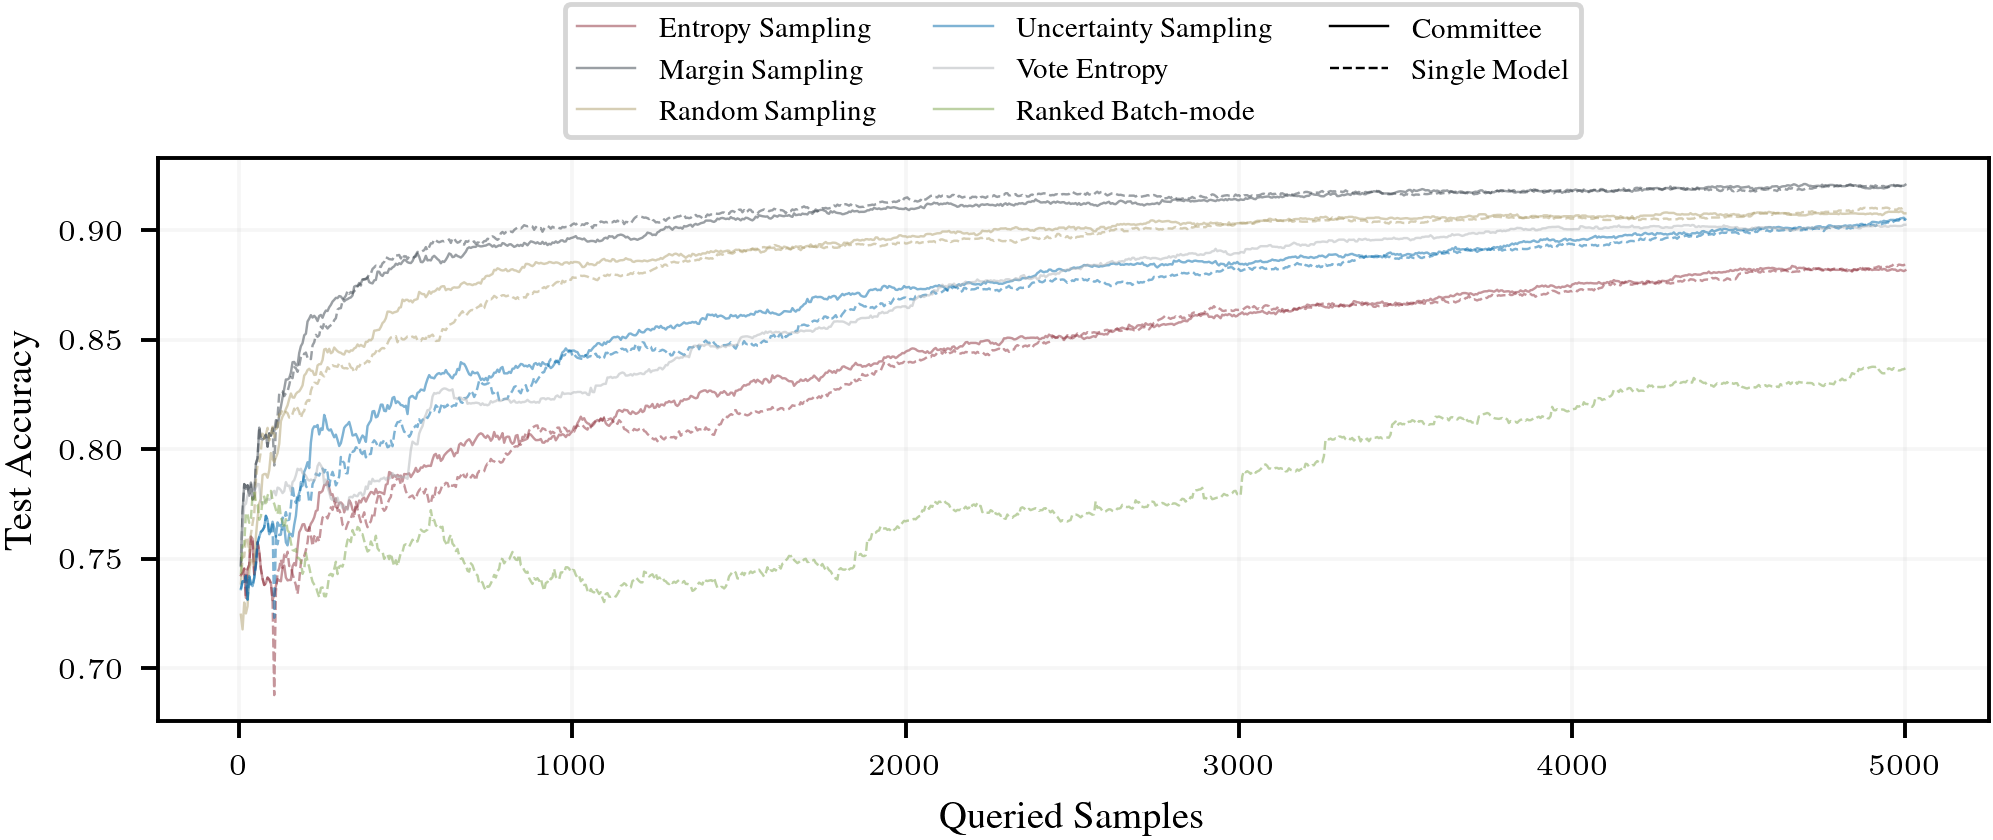

In [18]:
def plot_data(data:dict, x_ax_label:str, y_ax_label:str, title:str, whole_dataset_baseline:list, show_legend:bool=True, interpolation_method=align_data_lengths, file_name=None, column_size="half"):
    color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])
    
    plt.rcParams.update(bundles.icml2022(column=column_size, nrows=1, ncols=1))
    plt.rcParams.update({"figure.dpi": 350})
    if column_size == "full":
        figsize = plt.rcParams.get('figure.figsize')
        figsize[1] = figsize[1]/2
        plt.rcParams.update({'figure.figsize': figsize})
    plt.rcParams.update(cycler.cycler(color=palettes.tue_plot))
    plt.tight_layout()
    
    max_iterations = max([len(l) for i, l in data.items()]) # In case, the lengths of the input vectors do not match.
    r_b_u = data.pop('ranked_batch_mode')
    for method, d in data.items():
        is_committee = "committee" in method
        query_method = method.replace("_committee", "") # Extract query method (without duplicates)
        if query_method not in query_colors:
            query_colors[query_method] = next(color_cycle)
        
        # Check if interpolation is needed in case of different sized vectors
        num_queries = len(d)
        if num_queries < max_iterations:
            factor = int(max_iterations/num_queries)
            d = interpolation_method(d, factor)
        
        linestyle = "--" if is_committee else "-"
        plt.plot([x*5 for x in range(1, max_iterations + 1)], 
                 d, 
                 label=clear_names[query_method] if not is_committee or query_method=='vote_entropy' else None,
                 linewidth=line_width, 
                 linestyle=linestyle if not query_method=='vote_entropy' else '-',
                 color=query_colors[query_method], 
                 alpha=line_alpha)
    # Plot ranked batch mode separately as only the single model was trained
    if 'ranked_batch_mode' not in query_colors:
            query_colors['ranked_batch_mode'] = next(color_cycle)
    plt.plot([x*5 for x in range(1, max_iterations + 1)],
             r_b_u,
             label='Ranked Batch-mode',
             linewidth=line_width, 
             linestyle='--',
             color=query_colors['ranked_batch_mode'], 
             alpha=line_alpha)
    
    # plt.axhline(y=whole_dataset_baseline[-1], color='black', linestyle='-', label='whole_dataset', linewidth=line_width) # Theoretical maximum (Model with the whole MNIST Train Dataset)
    # Add labels, legend, and title
    plt.xlabel(x_ax_label)
    plt.ylabel(y_ax_label)
    if title is not None:
        plt.title(title)
    
    if show_legend:
        handles, labels = plt.gca().get_legend_handles_labels()
        unique_labels = dict(zip(labels, handles))
        # Add single model and committee example lines
        single_model_line = plt.Line2D([0], [0], color='black', linestyle='-', linewidth=line_width, label='Committee')
        committee_line = plt.Line2D([0], [0], color='black', linestyle='--', linewidth=line_width, label='Single Model')
        handles[-1].set_linestyle('-') # Set linestyle of ranked batch mode to - for uniform design
        plt.legend(
            handles=list(unique_labels.values()) + [single_model_line, committee_line],
            loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=3
        )
    handles[-1].set_linestyle('--') # Set linestyle of Ranked batch mode bach to --
    plt.grid(alpha=0.1)
    if file_name is not None:
        plt.savefig(os.path.join(figs_dir, file_name), dpi=350)
    plt.show()

C:\Users\lukas\AppData\Local\Temp\ipykernel_22956\273229614.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


UnboundLocalError: cannot access local variable 'handles' where it is not associated with a value

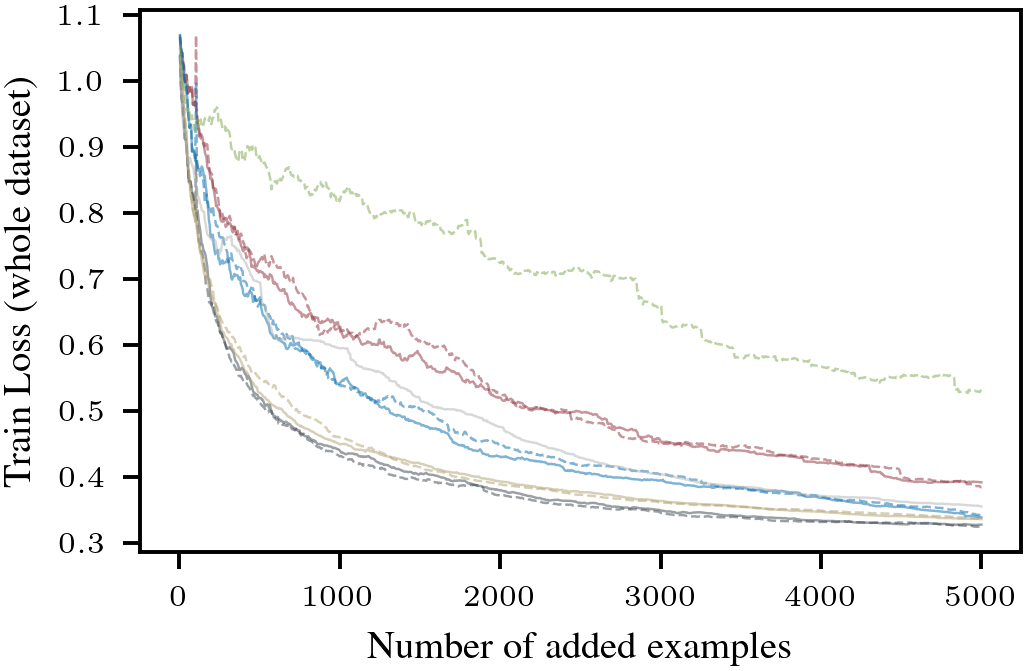

In [19]:
plot_data(data=train_losses.copy(), 
          x_ax_label="Number of added examples", 
          y_ax_label="Train Loss (whole dataset)", 
          title=None, 
          whole_dataset_baseline=train_losses_whole_dataset,
          show_legend=False, 
          file_name="train_loss.pdf")

In [ ]:
plot_data(data=test_losses.copy(), 
          x_ax_label="Queried Samples", 
          y_ax_label="Test Loss", 
          title=None, 
          whole_dataset_baseline=test_losses_whole_dataset,
          show_legend=False, 
          file_name='test_loss.pdf')

# Test Accuracy

C:\Users\lukas\AppData\Local\Temp\ipykernel_22956\273229614.py:11: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


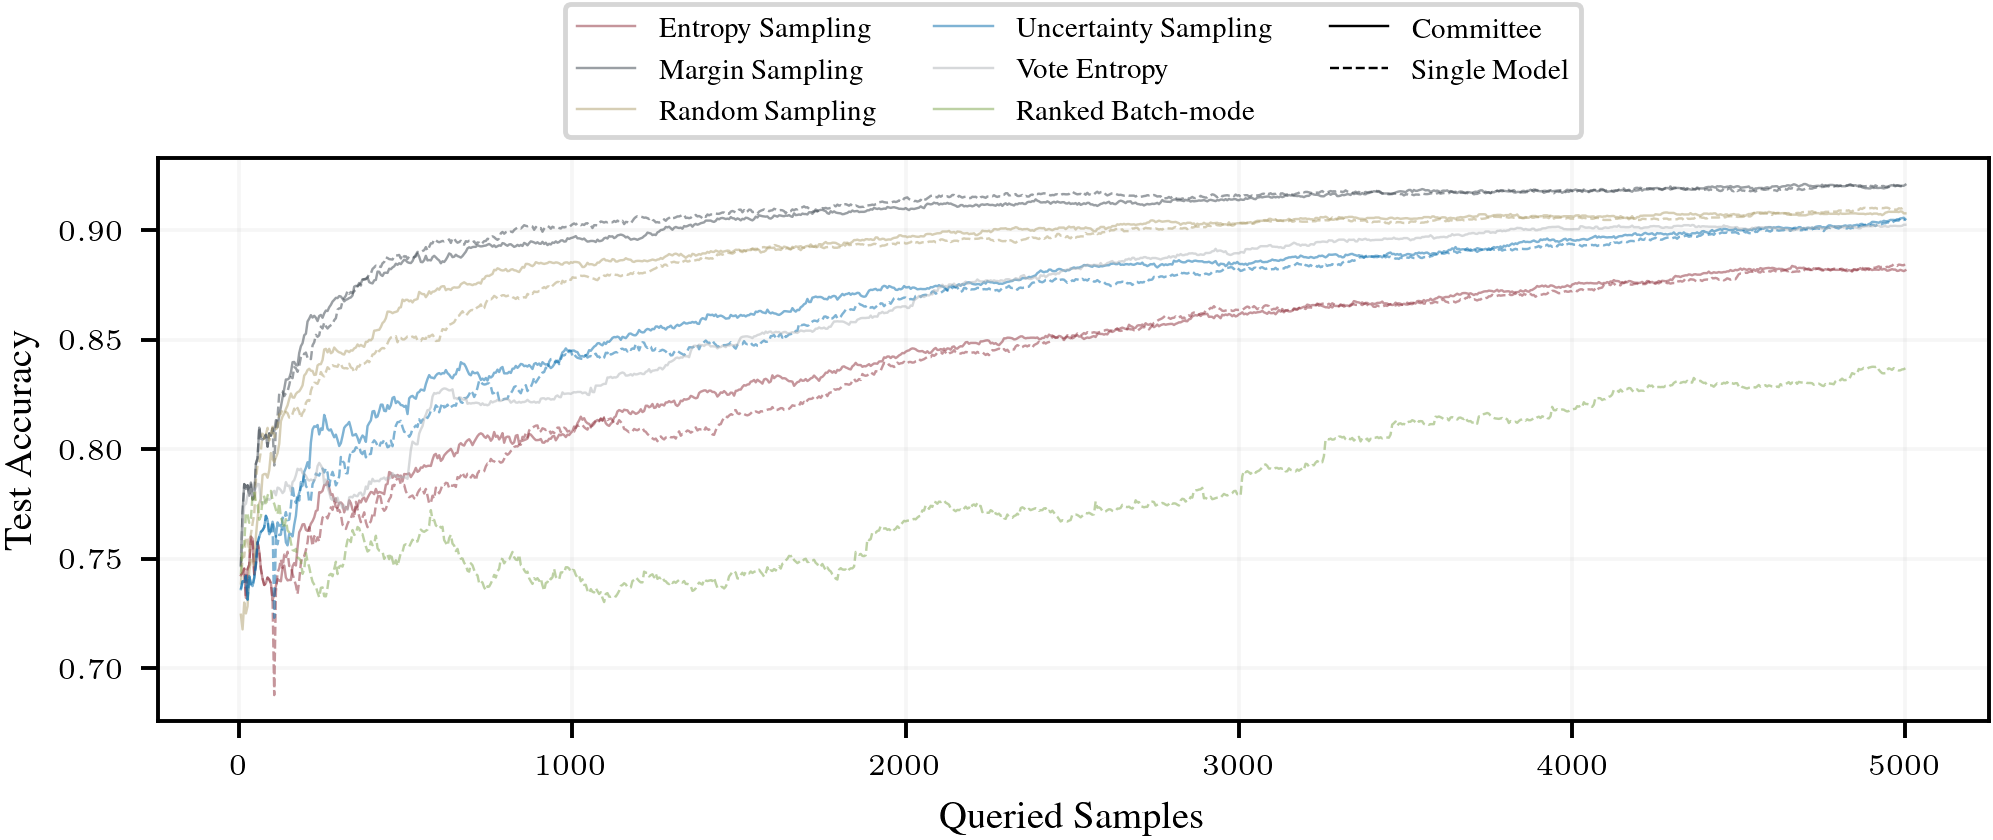

In [21]:
plot_data(data=test_accuracies.copy(), 
          x_ax_label="Queried Samples", 
          y_ax_label="Test Accuracy", 
          title=None, 
          whole_dataset_baseline=test_accuracies_whole_dataset, 
          column_size="full", 
          show_legend=True,
          file_name='test_accuracy.pdf')

# ROC Curve (One-vs-Rest)

Due to the fact that a ROC curve is more for a binary task as it plots the TPR vs FPR, and we have multiple classes, I opt out to use the One vs Rest approach. (Another option would be One vs One, where each class is compared to each other class but due to the fact that there are 10 classes in MNIST, this approach is not taken)

In [ ]:
line_width = 1

In [ ]:
for query_method, _ in models_list.items():
    plt.rcParams.update(bundles.icml2022(column="half", nrows=1, ncols=1))
    plt.rcParams.update({"figure.dpi": 350})
    plt.rcParams.update(cycler.cycler(color=palettes.tue_plot))
    
    y_hat_model = y_hats_probs[query_method]
    for c in classes:
        y_true_c = np.where(y_test == c, 1, 0)
        y_hat_c = y_hat_model[:, c]
        
        fpr, tpr, _ = roc_curve(y_true_c, y_hat_c)
        roc_auc = auc(fpr, tpr)
    
        plt.plot(fpr, tpr, label=f'{c}: (AUC = {roc_auc:.2f})', linewidth=line_width, alpha=0.3)
        
    plt.plot([0, 1], [0, 1], linestyle='--', linewidth=line_width)  # this is the diagonal baseline
    
    plt.title(f'ROC Curves for {query_method}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(alpha=line_alpha)
    
    plt.show()

## Confusion Matrix

In [ ]:
print(bundles.icml2022(column='full'))

In [ ]:
for query_method in query_methods:
    plt.rcParams.update(bundles.icml2022(column="full", nrows=1, ncols=1))
    plt.rcParams.update({"figure.dpi": 350})
     # manually set the font size inside the confusion matrix
    fig, axs = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 1]}, constrained_layout=True)
    # fig.suptitle(clear_names[query_method])  # Use readable names
    fig.text(0.5, 0.85, clear_names[query_method], ha='center', va='bottom', fontsize=10)
    
    y_hat_model = y_hats_classes[query_method]
    y_hat_committee = y_hats_classes[f"{query_method}_committee"]

    cm_model = confusion_matrix(y_test, y_hat_model)
    cm_committee = confusion_matrix(y_test, y_hat_committee)
    # Normalize
    cm_model = cm_model / cm_model.sum(axis=1, keepdims=True)
    cm_committee = cm_committee / cm_committee.sum(axis=1, keepdims=True)
    norm = mcolors.Normalize(vmin=0, vmax=1)
    
    # Model Confusion matrix
    disp_model = ConfusionMatrixDisplay(confusion_matrix=cm_model, display_labels=classes)
    disp_model.plot(cmap="Blues", ax=axs[1], xticks_rotation='horizontal', colorbar=False, values_format=None)
    axs[1].set_title('Committee', fontsize=10)
    
    # Committee Confusion matrix
    disp_committee = ConfusionMatrixDisplay(confusion_matrix=cm_committee, display_labels=classes)
    im = disp_committee.plot(cmap="Blues", ax=axs[0], xticks_rotation='horizontal', colorbar=False, values_format=None)
    axs[0].set_title('Single Model', fontsize=10)
    
    cbar = fig.colorbar(im.im_, ax=axs, location='right', shrink=0.63175, aspect=15, pad=0.05, norm=norm)
    cbar.set_label("Frequency")
    # Overwrite values in matrix to have 2 digits
    for num in axs[0].texts:
        num.remove()
    for num in axs[1].texts:
        num.remove()
    for i in range(cm_model.shape[0]):
        for j in range(cm_model.shape[1]):
            axs[0].text(j, i, f"{cm_model[i, j]:.2f}", 
                        ha="center", va="center", color="black" if i!=j else "white",
                        fontsize=8)

    for i in range(cm_committee.shape[0]):
        for j in range(cm_committee.shape[1]):
            axs[1].text(j, i, f"{cm_committee[i, j]:.2f}", 
                        ha="center", va="center", color="black" if i!=j else "white",
                        fontsize=8)
    
    plt.savefig(os.path.join(figs_dir, f'conf_mat_{query_method}.pdf'), dpi=350)
    plt.show()

## Precision, Recall, F1-Score

- Macro: Average accuracy equally across all classes. --> Metric is for each class independently
- Micro: Account for class imbalance by aggregating globally. --> Imbalance-aware
- Weighted Average: Weights class metrics by number of true samples in each classes support. Classes with more samples have larger influence.

In [ ]:
for query_method, y_preds in y_hats_classes.items():
    print(f"{query_method}: \n"
          f"{classification_report(y_test, y_preds, target_names=[str(c) for c in classes])}")

In [ ]:
for method, accs in test_accuracies.items():
    is_committee = "committee" in method
    query_method = method.replace("_committee", "")
    print(f'{clear_names[query_method]} {"committee" if is_committee else "single model"}: {accs[-1]}')

In [ ]:
test_accuracies_whole_dataset[-1]

In [ ]:
method = 'uncertainty_sampling'
l1 = np.array(models_list[f'{method}'][1]['queries']).flatten()
l2 = np.array(models_list[f'{method}_committee'][1]['queries']).flatten()
is_equal = l1 == l2
print(is_equal.all())

In [22]:
print(models_list['vote_entropy_committee'][1]['test_acc'][-1])
print(models_list['entropy_sampling'][1]['test_acc'][-1])
print(models_list['entropy_sampling_committee'][1]['test_acc'][-1])

0.9025
0.8817
0.8846


In [ ]:
query_method = 'entropy_sampling'
plt.rcParams.update(bundles.icml2022(column="full", nrows=1, ncols=1))
plt.rcParams.update({"figure.dpi": 350})
 # manually set the font size inside the confusion matrix
fig, axs = plt.subplots(nrows=1, ncols=2, gridspec_kw={'width_ratios': [1, 1]}, constrained_layout=True)
# fig.suptitle(clear_names[query_method])  # Use readable names
fig.text(0.5, 0.85, clear_names[query_method], ha='center', va='bottom', fontsize=10)

y_hat_model = y_hats_classes[query_method]
y_hat_committee = y_hats_classes[f"{query_method}_committee"]

cm_model = confusion_matrix(y_test, y_hat_model)
cm_committee = confusion_matrix(y_test, y_hat_committee)
# Normalize
cm_model = cm_model / cm_model.sum(axis=1, keepdims=True)
cm_committee = cm_committee / cm_committee.sum(axis=1, keepdims=True)
norm = mcolors.Normalize(vmin=0, vmax=1)

# Model Confusion matrix
disp_model = ConfusionMatrixDisplay(confusion_matrix=cm_model, display_labels=classes)
disp_model.plot(cmap="Blues", ax=axs[1], xticks_rotation='horizontal', colorbar=False, values_format=None)
axs[1].set_title('Committee', fontsize=10)

# Committee Confusion matrix
disp_committee = ConfusionMatrixDisplay(confusion_matrix=cm_committee, display_labels=classes)
im = disp_committee.plot(cmap="Blues", ax=axs[0], xticks_rotation='horizontal', colorbar=False, values_format=None)
axs[0].set_title('Single Model', fontsize=10)

cbar = fig.colorbar(im.im_, ax=axs, location='right', shrink=0.63175, aspect=15, pad=0.05, norm=norm)
cbar.set_label("Frequency")
# Overwrite values in matrix to have 2 digits
for num in axs[0].texts:
    num.remove()
for num in axs[1].texts:
    num.remove()
for i in range(cm_model.shape[0]):
    for j in range(cm_model.shape[1]):
        axs[0].text(j, i, f"{cm_model[i, j]:.2f}", 
                    ha="center", va="center", color="black" if i!=j else "white",
                    fontsize=8)

for i in range(cm_committee.shape[0]):
    for j in range(cm_committee.shape[1]):
        axs[1].text(j, i, f"{cm_committee[i, j]:.2f}", 
                    ha="center", va="center", color="black" if i!=j else "white",
                    fontsize=8)

plt.show()